## Table Of Content
1. [Libraries](#libraries)
2. [Data](#data)
3. [Data Dictionary](#dictionary)
4. [Data Inspection](#inspection)
5. [Data Cleaning](#clean)
6. [Explortatory Data Analysis](#eda)
7. [Modelling](#model)
8. [Testing](#testing)

<a name="libraries"><a/>
## Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from plotnine import *

from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict  # train_test_split,
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score

In [2]:
# Custom Functions
import function as cfun

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a name="data"><a/>
## Data

In [3]:
train = pd.read_csv('data/train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('data/test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('data/SampleSubmission.csv')

<a name="dictionary"><a/>
### Data Dictionary

**Sensor1_PM2.5, Sensor2_PM2.5 ::** These are recorded PM2.5 from Sensor 1 and Sensor 2.  
**NOTE :** *PM2.5 also called Fine particulate matter are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated. (PM2.5 are complex because they can be made up of numerous types of chemicals and particles and they can also be partly liquid. measured in micrograms per cubic meter. "a microgram is a unit of weight, there are a million micrograms in a gram, & a pound = 450 grams."*  

**Temparature ::** This is the degree or indensity of heat present when each PM2.5 was recorded using a Celsius scale. Note that higher tempemperature leads to low air quality. Also When the weather is hot primary sources of pollutants tend to increase.  

**Relative_Humidity ::** Relative humidity is the amount of water vapor in the air, expressed as a percentage of the maximum amount of water vapor the air can hold at the same temperature. A high humidity increases the rate of harmful or toxic chemicals in the air. 

<a name="inspection"><a/>
### Data Inspection
1. [Data Info](#info)
2. [Missing Values](#missing)
3. [Duplicates](#duplicate)
4. [Outliers](#outlier)

<a name="info"><a/>
#### Data Info

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 297177 non-null  object        
 1   Datetime           297177 non-null  datetime64[ns]
 2   Sensor1_PM2.5      293563 non-null  float64       
 3   Sensor2_PM2.5      293563 non-null  float64       
 4   Temperature        293628 non-null  float64       
 5   Relative_Humidity  293628 non-null  float64       
 6   Offset_fault       297177 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 15.9+ MB


There are 297,177 records and 7 variables of airquality data in the training data set, also the non null count shows that tamperature, relative humidity and both sensors have missing values in them.

<a name="missing"><a/>
#### Missing Values

In [11]:
na_df = train.isnull().sum().to_frame().rename(columns = {0: "Number of Missing Value"})
na_df["percentage"] = round((na_df["Number of Missing Value"] / train.shape[0])*100, 3)
na_df

,Number of Missing Value,percentage
ID,0,0.000
Datetime,0,0.000
Sensor1_PM2.5,3614,1.216
Sensor2_PM2.5,3614,1.216
Temperature,3549,1.194
Relative_Humidity,3549,1.194
Offset_fault,0,0.000


Both PM2.5 sensors have 3,614 missing values which is 1.2% of the train data set, while both tempaerature and relative humidity have 3,549 (1.2%) of missing data.

##### Question: 
There are similar missing number of values for both sensors and also temperature and relative humidity, so are these missing records similar in the data.

In [12]:
def related_missing_record(df, cols):
    check_1 = df.loc[df[cols[0]].isna()].loc[df[cols[1]].notna()].shape[0]
    check_2 = df.loc[df[cols[1]].isna()].loc[df[cols[0]].notna()].shape[0]
    return check_1 == check_2

In [ ]:
print(f"Both Sensor ::\n{related_missing_record(train, ['Sensor1_PM2.5', 'Sensor2_PM2.5'])}\n")
print(f"Train Temperature & Relative Humidity::\n{related_missing_record(train, ['Temperature', 'Relative_Humidity'])}\n")

Both Sensor ::
True

Train Temperature & Relative Humidity::
True



Looks like there were faliure/reason for skipping data entry during a specific period of time for both sensors. let get the minimum and maximum date for this missing record.

In [14]:
for col in ["Sensor1_PM2.5", "Temperature"]:
    print(f"{col} ::\n{train.loc[train[col].isna()]['Datetime'].agg(['min', 'max'])}\n")

Sensor1_PM2.5 ::
min   2021-10-18 10:00:13
max   2021-10-22 14:58:43
Name: Datetime, dtype: datetime64[ns]

Temperature ::
min   2021-10-30 11:00:31
max   2022-01-19 14:59:34
Name: Datetime, dtype: datetime64[ns]



<a name="duplicate"><a/>
#### Duplicates

In [15]:
train.duplicated().sum()

0

<a name="outlier"><a/>
#### Outliers

c:\Users\AYOMIDE\vs-python\m_learn\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


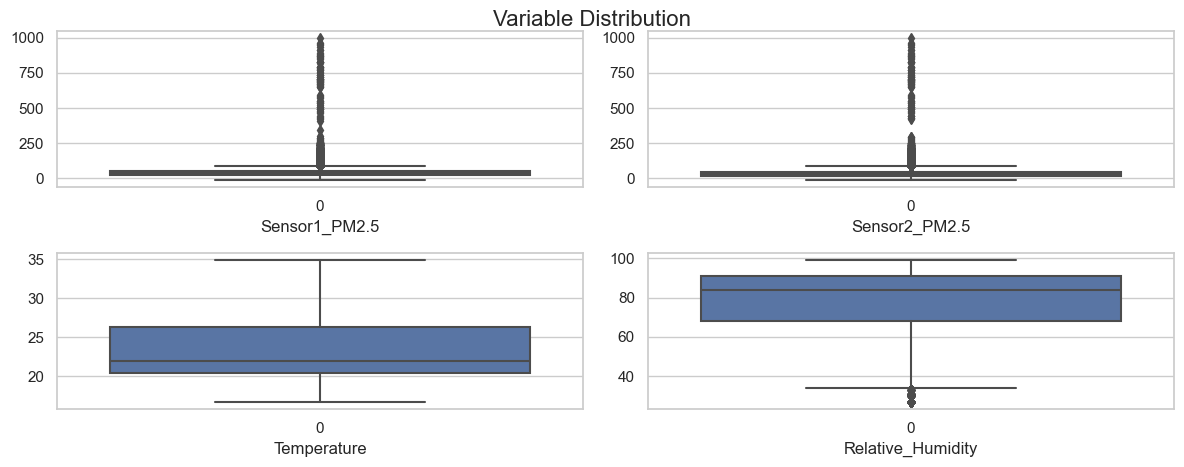

In [18]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 5))
fig.suptitle('Variable Distribution', y = 0.93, fontsize = 16)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature', 'Relative_Humidity']):
    sns.boxplot(train[name], ax = ax)
    ax.set_xlabel(name)

In [17]:
outlier_cols = ["Sensor1_PM2.5", "Sensor2_PM2.5", "Relative_Humidity"]
for col in outlier_cols:
    print(f"{col} Outlier :: {cfun.get_outlier(train, col, 1.5)}")
    print("-"*20)

Sensor1_PM2.5 Outlier :: [-18.055, 89.905]
--------------------
Sensor2_PM2.5 Outlier :: [-22.555000000000003, 89.64500000000001]
--------------------
Relative_Humidity Outlier :: [33.5, 125.5]
--------------------


Both Sensors have some extrem large values that shows that there where some times when the sensors picked up dengerous level of Fine particulate matter around the area.

##### Question:
Are these extreme values somehow related to the periods when the pm2.5 sensors where condsidered faulty.

In [18]:
for col in ["Sensor1_PM2.5", "Sensor2_PM2.5"]:
    print(f"{col} Outlier :: {cfun.get_outlier(train.query('Offset_fault == 0'), col, 1.5, typ='upper')}\n")
    print(f"Max {col} value :: {train.query('Offset_fault == 0')[col].max()}\n\n")

Sensor1_PM2.5 Outlier :: 92.72

Max Sensor1_PM2.5 value :: 997.96


Sensor2_PM2.5 Outlier :: 92.025

Max Sensor2_PM2.5 value :: 997.26




In [19]:
for col in ["Sensor1_PM2.5", "Sensor2_PM2.5"]:
    print(f"{col} Outlier :: {cfun.get_outlier(train.query('Offset_fault == 1'), col, 1.5, typ='upper')}\n")
    print(f"Max {col} value :: {train.query('Offset_fault == 1')[col].max()}\n\n")

Sensor1_PM2.5 Outlier :: 81.525

Max Sensor1_PM2.5 value :: 283.18


Sensor2_PM2.5 Outlier :: 71.0

Max Sensor2_PM2.5 value :: 248.4




Both occations show that the extreme values are present inspite of whether the sensor is considered faulty or not.

In [20]:
for col in outlier_cols:
    print(f"Number of Outlier in {col} is {cfun.filter_outlier(train, col, 'inner').shape[0]:,}")
    print("-"*46)

Number of Outlier in Sensor1_PM2.5 is 17,402
----------------------------------------------
Number of Outlier in Sensor2_PM2.5 is 15,463
----------------------------------------------
Number of Outlier in Relative_Humidity is 772
----------------------------------------------


<a name="clean"><a/>
### Data Cleaning
The train data will be restructured for exploration.

In [18]:
# Dropping missing values
e_train = train.dropna().copy()
e_train.shape

(290014, 7)

<a name="eda"><a/>
## Exploratory Data Analysis
1. [Additional Variables](#add_var)
1. [Univariate Analysis](#uni)
2. [Multivarite Analysis](#multi)
3. [Correlation](#corr)

<a name="add_var"><a/>
### Additional Variables

The sensors PM2.5 records are numeric, a categorical variable will be created to distinguish this records for better data exploration.

In [19]:
e_train = cfun.add_pmCategory(e_train, ordinal=False)

for col in ["S1_AQI", "S2_AQI"]:
    e_train[col] = e_train[col].astype("category") 
    e_train[col] = e_train[col].cat.reorder_categories(["Good", "Moderate", "Unhealthy (SG)", "Unhealthy", "Very Unhealthy", "Hazardous"], ordered = True)

Defining Air Quality Index Categories
1. **Good** :: Little to no risk (PM2.5 from 0 - 12.0)  
2. **Moderate** :: Unusually sensitive individuals may experience respiratory symptoms. (PM2.5 from 21.1 - 35.4)  
3. **Unhealthy** (for sensitive groups) :: Increasing likelihood of respiratory symptoms in sensitive individuals. (PM2.5 from 35.5 - 55.4)
4. **Unhealthy** :: Increased respiratory effect in general population. (PM2.5 from 55.5 - 150.4)
5. **Very Unhealthy** :: Significant increase in respiratory effect in general population. (PM2.5 from 150.4 - 250.4)
6. **Hazardous** :: Serious risk of respiratory effect in general population (PM2.5 from 250.4 - 500.4)  
source: [U.S.Environmental Protection Agency](https//www.epa.gov)

The Datetime contains the timestamp of the data collection, from this variable the individual hour, month, and year will be extracted.

In [20]:
e_train = cfun.get_standAlone_dates(e_train, "Datetime", ["hour", "month", "year"])

Changing offset fault for better readability during exploration

In [21]:
e_train["faulty"] = e_train["Offset_fault"].replace({0: "No", 1: "Yes"})
e_train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,S1_AQI,S2_AQI,Hour,Month,Year,faulty
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0,Unhealthy (SG),Unhealthy (SG),4,11,2021,No
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0,Moderate,Moderate,18,11,2021,No
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0,Moderate,Moderate,9,11,2021,No
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0,Moderate,Moderate,18,1,2022,No
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0,Unhealthy (SG),Moderate,22,11,2021,No


<a name="uni"><a/>
### Univariate Analysis

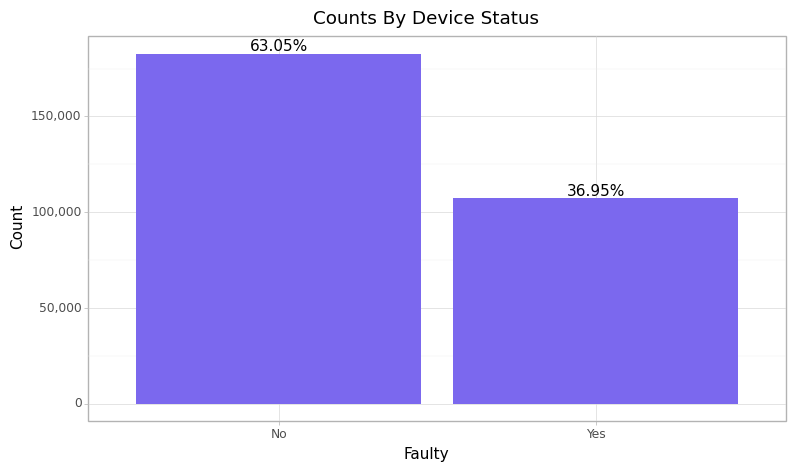

<ggplot: (80869490214)>

In [25]:
cfun.rec_count(e_train, "faulty", title = "Device Status", typ = "plt")

The outcome variable `offset fault`  contains only two categories which are 1/Yes for PM2.5 sensors that were considered sending faulty signals at the time and 0/No for sensors working well. From the bar chart above, there are less faulty sensors (36.95%) that faulty sensors (63.05%) overall.

In [12]:
e_train.select_dtypes("number").describe().applymap(lambda x: round(x, 3))

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Hour,Month,Year
count,290014.000,290014.000,290014.000,290014.000,290014.000,290014.000,290014.000,290014.000
mean,40.902,38.319,23.323,78.614,0.369,11.350,9.082,2021.208
std,28.598,28.723,3.842,14.792,0.483,6.969,4.195,0.406
min,-9.450,-9.700,16.700,27.000,0.000,0.000,1.000,2021.000
25%,22.570,19.620,20.400,68.000,0.000,5.000,10.000,2021.000
50%,36.650,33.850,21.900,84.000,0.000,11.000,11.000,2021.000
75%,49.550,47.700,26.300,91.000,1.000,17.000,12.000,2021.000
max,997.960,997.260,34.900,99.000,1.000,23.000,12.000,2022.000


In micrograms per cubic meter the minimum value for sensors 1 and 2 falls within the range -9.45 to -9.70 respectively while that maximum value falls within the range 997.96 to 997.26 respectively which shows only a very small difference, for the average value given that there are huge presence of outliers in both sensors it will be more accurate to look at the median value where 50% for sensor 1 fall between 36.65 and lower also for sensor 2 33.85 and lower.  

There was an average temperature of  23.32 degrees overall for the train set and for relative humidity 78.61.

#### Sensor 1 and 2 Distribution

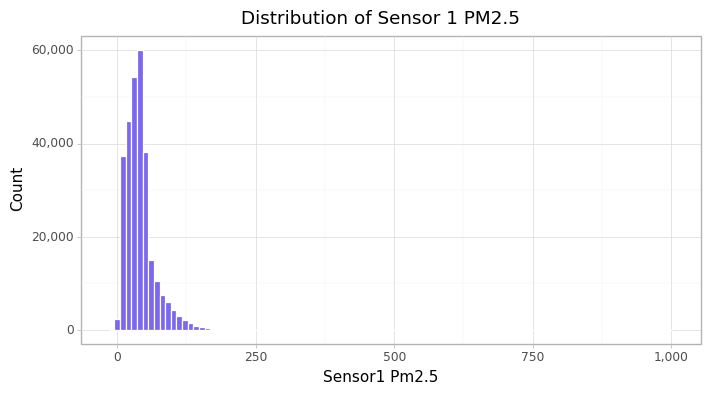

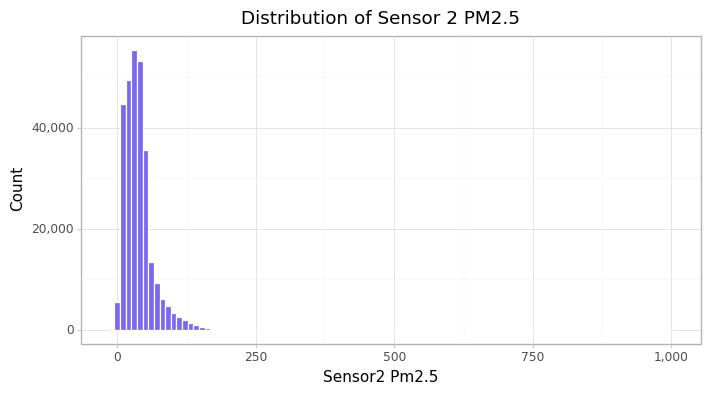

In [27]:
for col, sensor in zip(["Sensor1_PM2.5", "Sensor2_PM2.5"], [1, 2]):
    print(cfun.histPlot(e_train, col, bins = 100, title=f"Sensor {sensor} PM2.5"))

#### Air Quality Index

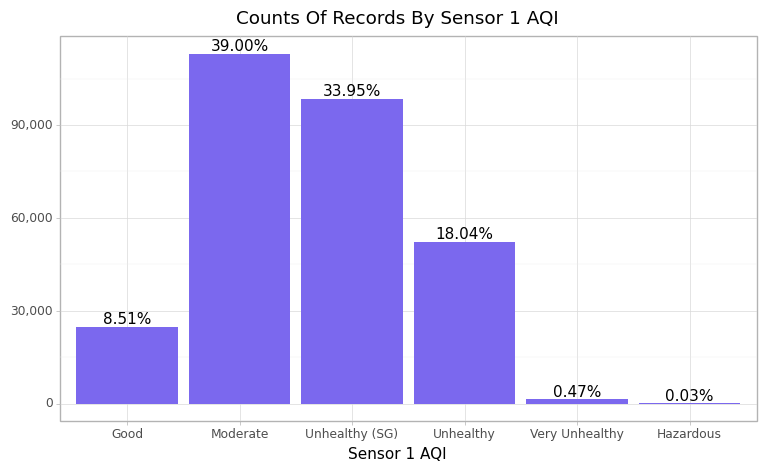

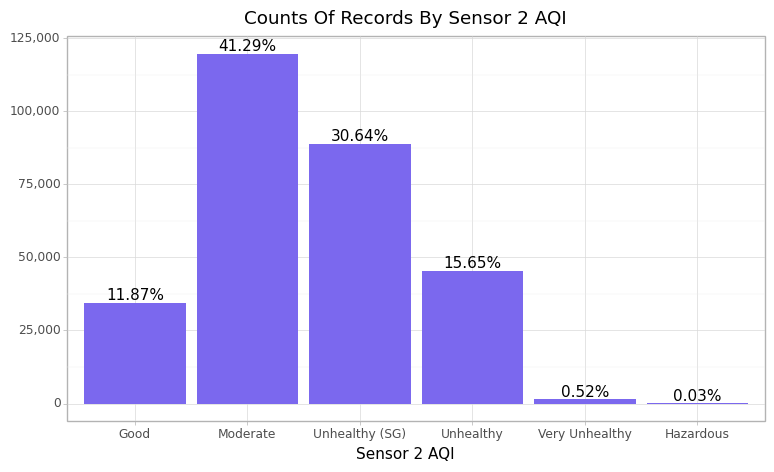

In [29]:
for col in ["S1_AQI", "S2_AQI"]:
    print(cfun.air_quality_count(e_train, col))

Sensor 2 Picked up more Good PM2.5 signals (11.87%) than sensor 1 (8.51%), both sensors have just 0.03% of it recodes as hazadious while the highest Air quality index category recorded was moderate level with 39% and 41% respectively for sensor 1 and 2.

#### Temperature

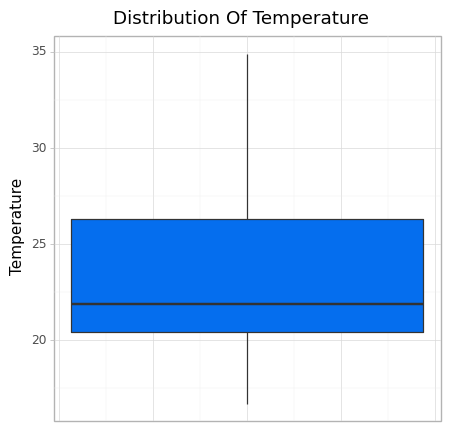

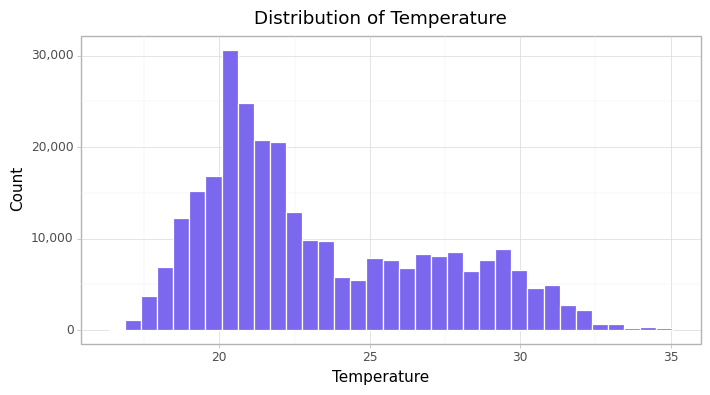

<ggplot: (80869548762)>

In [30]:
print(cfun.boxPlot(e_train, "Temperature"))
cfun.histPlot(e_train, "Temperature", bins=35)

Given that the distibution is skewed, it shows that there are more low temperatures recorded then high temperatures.

#### Relative Humidity

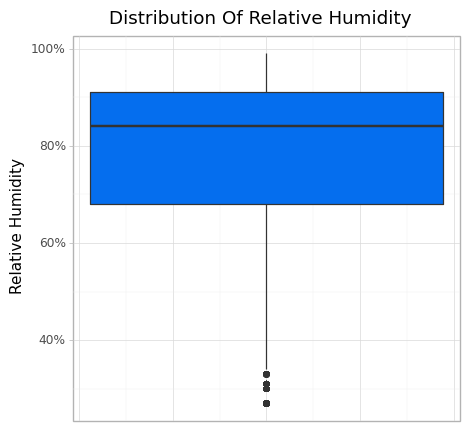

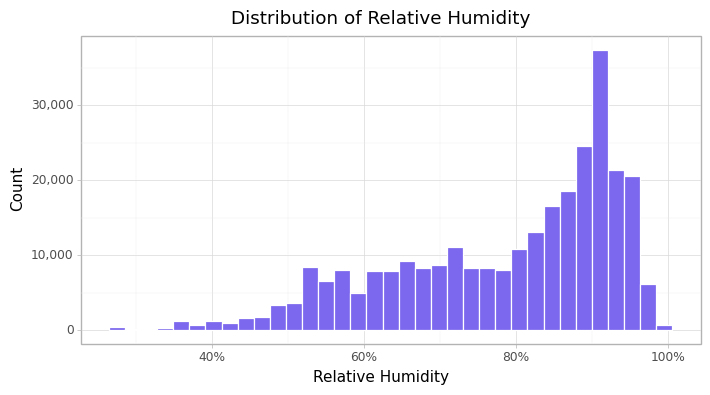

<ggplot: (80873476733)>

In [31]:
print(cfun.boxPlot(e_train, "Relative_Humidity", axis_text_suffix="%"))
cfun.histPlot(e_train, "Relative_Humidity", bins=35, axis_text_suffix="%")

More high relative humidity was recorded than low relative humidity Over the selected period.

#### DateTime

In [32]:
e_train["Datetime"].describe()

count                  290014
unique                 286694
top       2021-11-05 12:40:33
freq                        3
first     2021-10-15 16:00:31
last      2022-01-21 07:34:57
Name: Datetime, dtype: object

For the train data set the we can see that the records started from the 15th of October 2021 up to the 21st of january 2022.

##### Month

In [33]:
e_train["Month"].unique()

array([11,  1, 12, 10], dtype=int64)

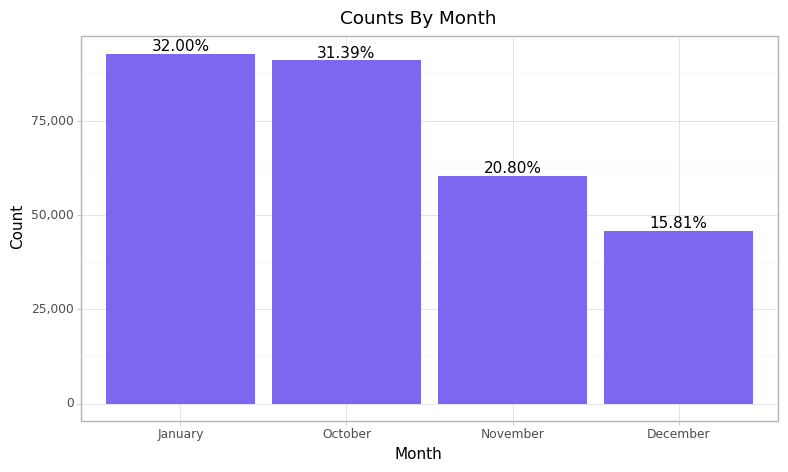

<ggplot: (80873454565)>

In [34]:
cfun.rec_count(e_train, "Month", rename_axis_text = ["January", "October", "November", "December"])

##### Year

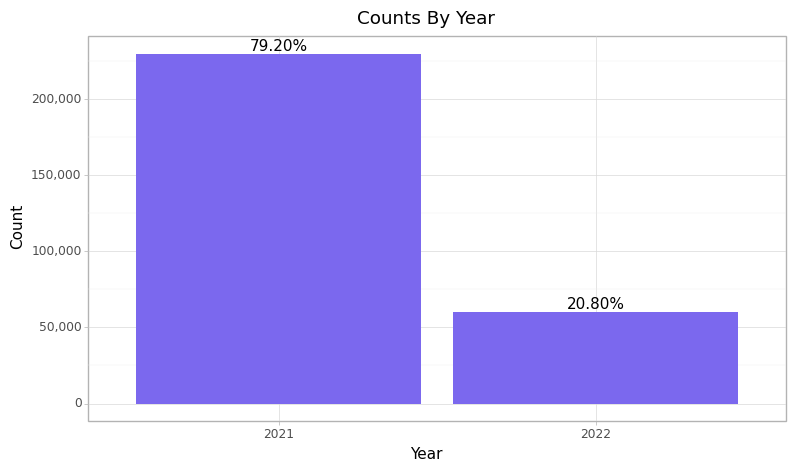

<ggplot: (80878660783)>

In [35]:
cfun.rec_count(e_train, "Year")

<a name="multi"><a/>
### Multivarite Analysis
1. [Device Status and Particulate Matter](#dspm)
2. [Temperature, Relative_Humidity and Device status](#trhds)
3. [Air Quality with Temperature & Relative Humidity](#aqithr)

<a name="dspm"><a/>
#### Device Status and Particulate Matter 

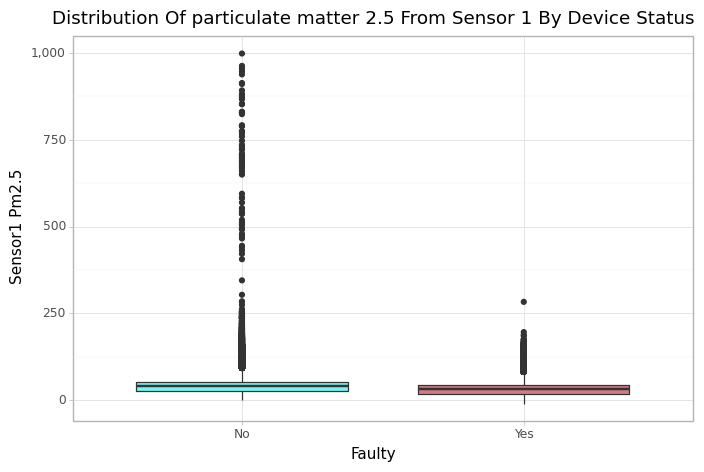

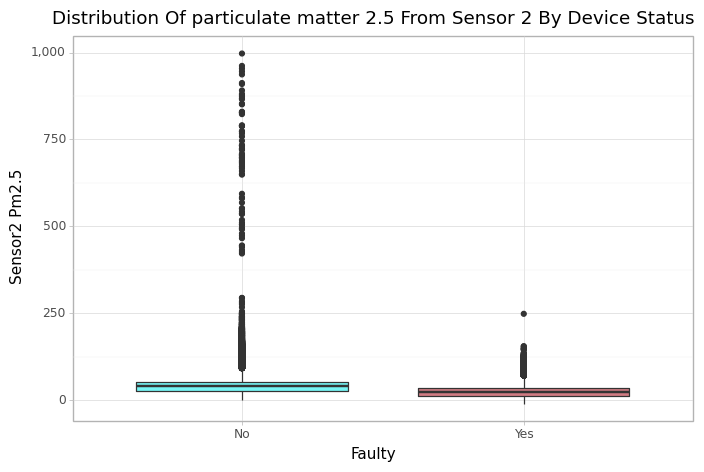

In [22]:
f_color = ["#75F4F4", "#D17B83"]
cols = ["Sensor1_PM2.5", "Sensor2_PM2.5"]
s_type = [1, 2]

for sensor, typ in zip(cols, s_type):
    print(cfun.boxPlot(e_train, 
                       num_var = sensor, 
                       cat_var = "faulty",
                       color = f_color,
#                        zoom = (0, 100),
                       title = [f"particulate matter 2.5 From Sensor {typ}", "Device Status"]))

For both sensors there where more extreme PM2.5 values recorded when no faulty signals was detected than when it was.

In [24]:
sen_agg = cfun.vars_longer_summary(e_train, 
                                   select_vars = ["faulty", "Sensor1_PM2.5", "Sensor2_PM2.5"], 
                                   var_name = "Sensor", value_name = "PM 2.5", 
                                   replace_rec = ["Sensor 1", "Sensor 2"])
sen_agg.drop("sum", axis=1)

,faulty,Sensor,min,mean,median,max
0,No,Sensor 1,0.00,44.757375,39.58,997.96
1,No,Sensor 2,0.18,45.115641,39.73,997.26
2,Yes,Sensor 1,-9.45,34.322565,31.98,283.18
3,Yes,Sensor 2,-9.70,26.719856,24.42,248.40


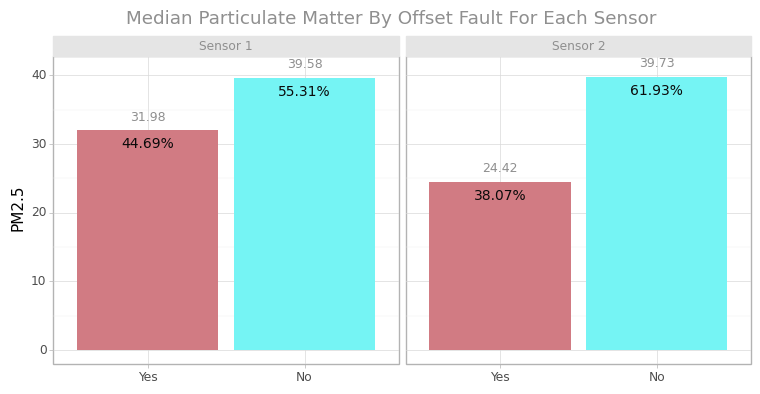

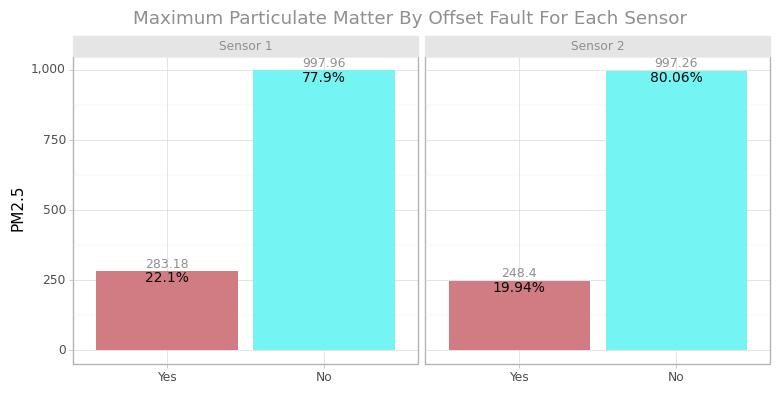

In [25]:
summary_fun = ["median", "max"]
plt_title = ["Median", "Maximum"]

for sumy_fun, plt_tl in zip(summary_fun, plt_title):
    print(cfun.facet_summary_plot2(df = sen_agg, cat_var = "faulty", num_var = sumy_fun, fill = "faulty", facet_by = "Sensor",
                                   ylab = "PM2.5", title = f"{plt_tl} Particulate Matter By Offset Fault For Each Sensor"))

The Median PM2.5 for sensor 2 when no signal offset fault was detected (61.93%) is higher than that of sensor 1 (55.31%) and the reverse is the case when a fault was detected. in conclusion sensor 1 had more offset faults than sensor 2.

##### Temperature, Relative Humidity and Device status

In [40]:
tr_agg = cfun.vars_longer_summary(e_train, 
                                  select_vars = ["faulty", "Temperature", "Relative_Humidity"],
                                  var_name  = "variable", value_name = "value")
tr_agg.drop("sum", axis=1)

,faulty,variable,min,mean,median,max
0,No,Relative_Humidity,27.0,78.639955,84.0,99.0
1,No,Temperature,16.7,23.314492,21.9,34.9
2,Yes,Relative_Humidity,27.0,78.570774,84.0,99.0
3,Yes,Temperature,16.7,23.336810,22.0,34.9


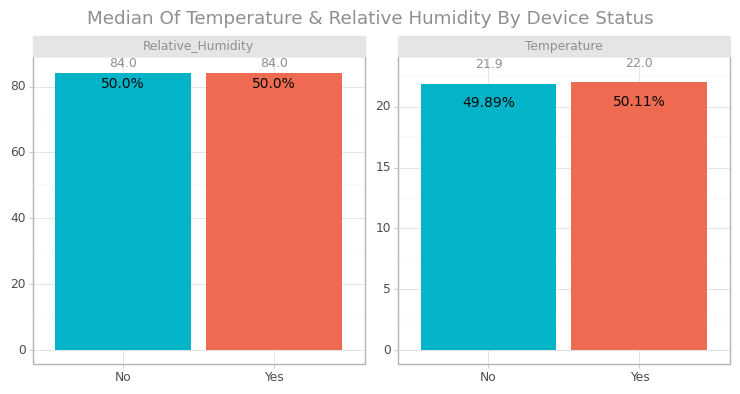

<ggplot: (80880517760)>

In [41]:
cfun.facet_summary_plot2(df = tr_agg, cat_var = "faulty", num_var = "median", fill = "faulty", facet_by = "variable", scales = "free_y", 
                         sb_aj=0.1, title = "Median Of Temperature & Relative Humidity By Device Status")

<a name="aqithr"><a/>
#### Air Quality with Temperature & Relative Humidity

##### Air quality from Sensor 1

In [27]:
aqi_tr =  cfun.vars_longer_summary(e_train, 
                                   select_vars=["S1_AQI", "Temperature", "Relative_Humidity"], 
                                   var_name   ="Variable", 
                                   value_name ="PM2.5")
aqi_tr.drop("sum", axis=1).head(5)

,S1_AQI,Variable,min,mean,median,max
0,Good,Relative_Humidity,27.0,65.902633,65.0,99.0
1,Good,Temperature,17.2,26.907975,27.6,34.9
2,Moderate,Relative_Humidity,27.0,73.571333,74.0,99.0
3,Moderate,Temperature,17.1,24.767452,24.9,34.9
4,Unhealthy (SG),Relative_Humidity,34.0,83.586812,87.0,99.0


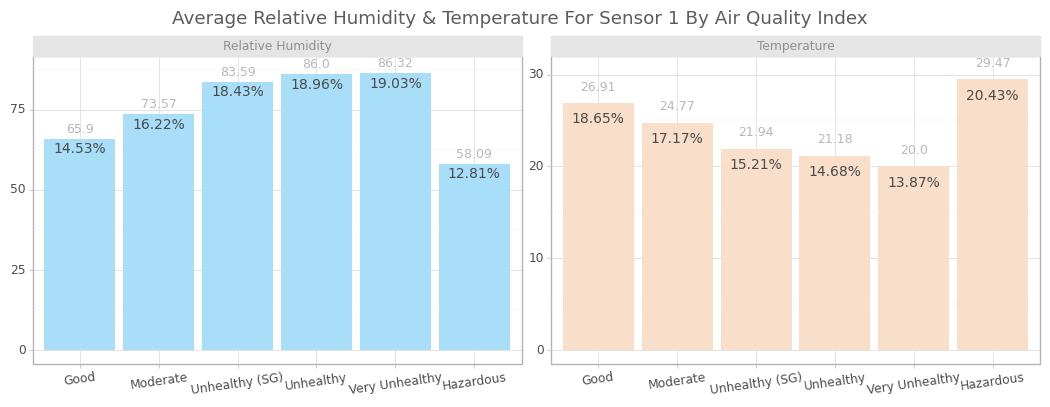

<ggplot: (110011157781)>

In [33]:
cfun.facet_summary_plot(aqi_tr, "S1_AQI", "mean", "Variable",
# colors=["#A9DEF9", "#F9DEC9"], # F1AB86
 sb_aj=0.06, title="Average Relative Humidity & Temperature For Sensor 1 By Air Quality Index")

##### Air quality from Sensor 2

In [44]:
aqi_tr =  cfun.vars_longer_summary(e_train, 
                                   select_vars=["S2_AQI", "Temperature", "Relative_Humidity"], 
                                   var_name   ="Variable", 
                                   value_name ="PM2.5")
aqi_tr.drop("sum", axis=1).head(5)

,S2_AQI,Variable,min,mean,median,max
0,Good,Relative_Humidity,27.0,66.620695,65.0,99.0
1,Good,Temperature,17.2,26.722606,27.5,34.9
2,Moderate,Relative_Humidity,27.0,75.574615,78.0,99.0
3,Moderate,Temperature,16.9,24.209235,23.5,34.9
4,Unhealthy (SG),Relative_Humidity,34.0,83.600160,87.0,99.0


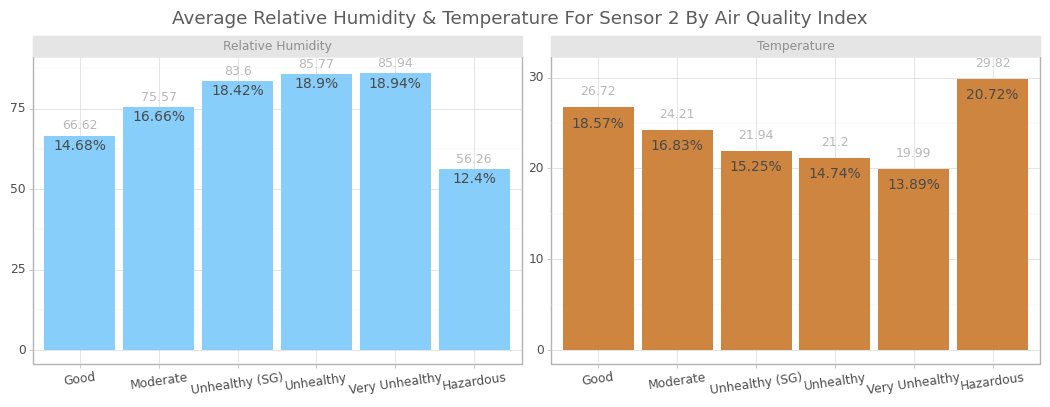

<ggplot: (80881608356)>

In [45]:
cfun.facet_summary_plot(aqi_tr, "S2_AQI", "mean", "Variable", sb_aj=0.06, title="Average Relative Humidity & Temperature For Sensor 2 By Air Quality Index")

For relative humidity using the above chart the higher the critical level of PM2.5 the higher the relative humidity on an average with the exception of hazardous level. while for temperature the higher the critical level of PM2.5 the lower the degree of temperature on an average with only the exception of hazardous level.

<a name="corr"><a/>
### Correlation

<Figure size 2700x1200 with 0 Axes>

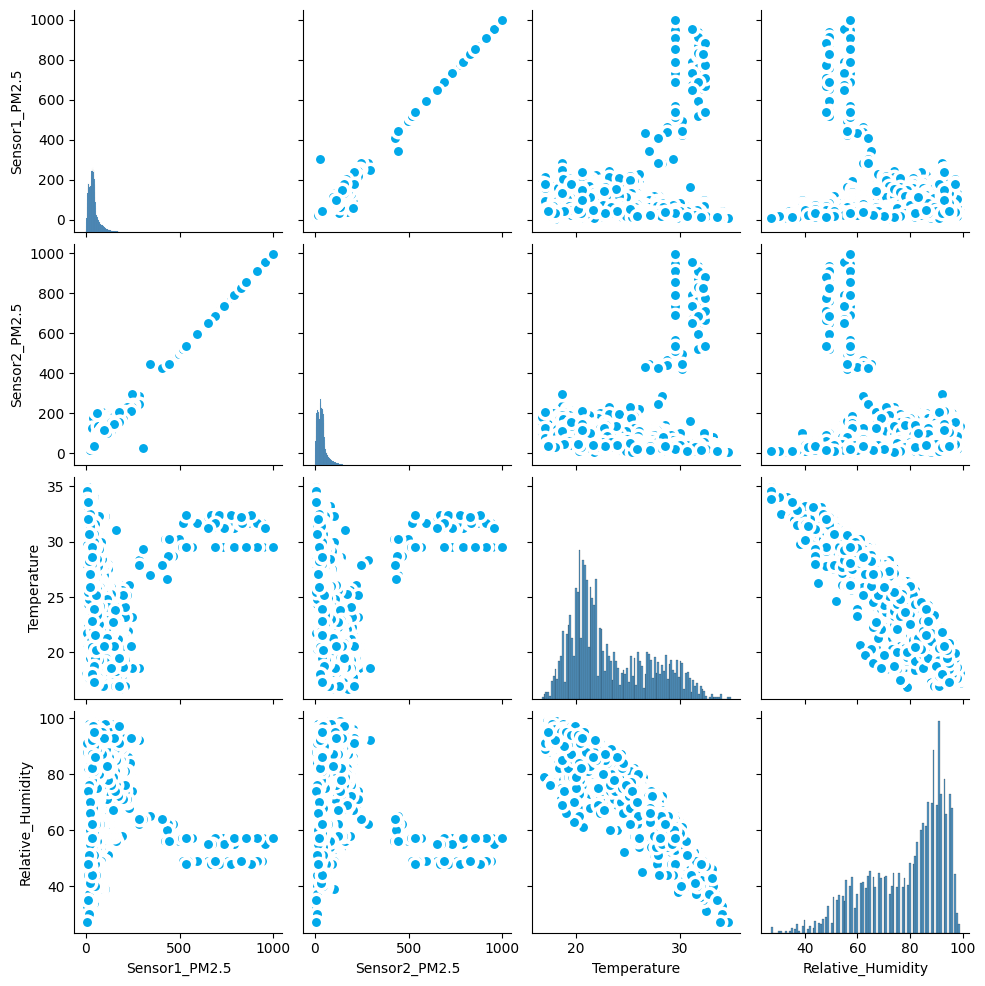

In [35]:
plt.figure(figsize = (27, 12))
num_cols = ['Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature', 'Relative_Humidity']
sns.pairplot(e_train[num_cols], kind = "scatter", plot_kws = dict(s=80, edgecolor="white", linewidth=2.5, color="#02A9EA"))
plt.show()

In [47]:
# Ordinal Encoding
corr_df = e_train.copy()

for col in ["S1_AQI", "S2_AQI"]:
    corr_df[col] = corr_df[col].replace({"Hazardous"     : 0, 
                                         "Very Unhealthy": 1, 
                                         "Unhealthy"     : 2, 
                                         "Unhealthy (SG)": 3, 
                                         "Moderate"      : 4, 
                                         "Good"          : 5})
    corr_df[col] = corr_df[col].astype("int64")

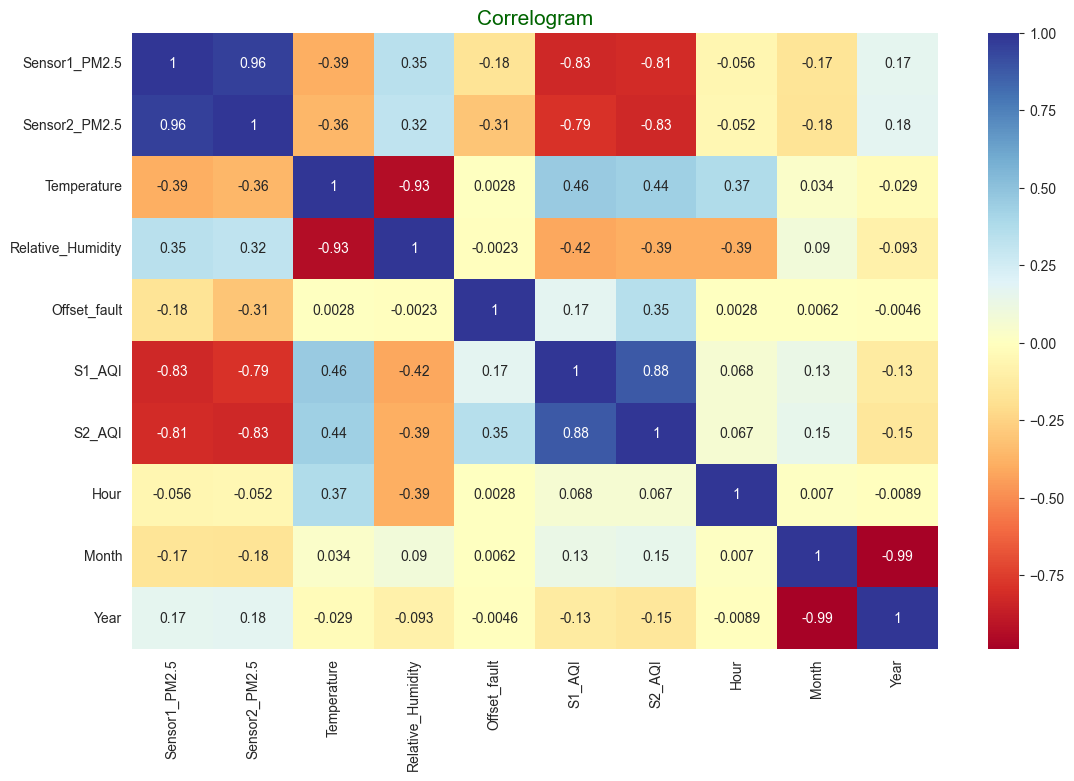

In [48]:
cor = corr_df.select_dtypes(["int64", "float64"]).corr()

plt.figure(figsize = (13, 8))
sns.heatmap(cor, cmap = 'RdYlBu', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

Both sensors 1 & 2 are highly positively correlated with each other.  
Air quality index(AQI) from both sensors are negatively correlated with the PM2.5 values.    
Temperature have a positive correlation with AQI while Relative Humidity have a negative correlation with AQI.  

<a name="model"><a/>
##  Modelling

For the training set all missing values will be removed from the data.  
Additional variables such as an ordinal air quality index as integer for both sensors will be added to the training set.  
Also the hour and day of the year will be extracted from the datetime variable after which the datetime variable will be dropped with the Id variable as they are both high cardinality features.

In [9]:
ord_train = train.sort_values(by="Datetime")

add_df = cfun.add_attributes(ord_train, drop_nan_value=True, fill_nan_value=False)

train_c = add_df.drop_missing_value()
train_c = add_df.add_air_quality_index()
train_c = add_df.add_period_variables(hour=True, dayofyear=True)
train_c = train_c.drop(["ID", "Datetime"], axis = 1)

In [10]:
train_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290014 entries, 116880 to 226302
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Sensor1_PM2.5      290014 non-null  float64
 1   Sensor2_PM2.5      290014 non-null  float64
 2   Temperature        290014 non-null  float64
 3   Relative_Humidity  290014 non-null  float64
 4   Offset_fault       290014 non-null  int64  
 5   S1_AQI             290014 non-null  int64  
 6   S2_AQI             290014 non-null  int64  
 7   Hour               290014 non-null  int64  
 8   Day_Of_Year        290014 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 22.1 MB


In [11]:
outcome = "Offset_fault"
X = train_c.drop(outcome, axis = 1)
y = train_c[outcome]

feature_names = list(train_c.drop(outcome, axis = 1).columns)

In [12]:
num_features = list(X.select_dtypes("number").columns)
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features)
])

X = full_pipeline.fit_transform(X)

In [13]:
# Transformed X
X

array([[-1.10957703, -1.01101351,  1.71196075, ...,  1.66087637,
         0.66730492,  0.20484599],
       [-1.08300205, -0.94242651,  1.71196075, ...,  1.66087637,
         0.66730492,  0.20484599],
       [-1.20189013, -1.22443398,  1.71196075, ...,  1.66087637,
         0.66730492,  0.20484599],
       ...,
       [ 0.11881666,  0.48919661, -1.67174045, ..., -0.52823302,
        -0.62421669, -1.84915195],
       [ 0.27721755,  0.2761243 , -1.67174045, ..., -0.52823302,
        -0.62421669, -1.84915195],
       [-0.01650596, -0.22243706, -1.67174045, ...,  0.56632168,
        -0.62421669, -1.84915195]])

In [14]:
def cross_validation(model, x=X, y=y, model_name="model", cv=5):
    y_pred = cross_val_predict(model, x, y, cv=cv, n_jobs=-1) 
        
    print(f"{model_name}\n{'='*50}")
    
    print(f"Confusion Matrix ::-\n{confusion_matrix(y, y_pred)}")
    print(50*"-","\n")
    print(f"Accuracy :: {accuracy_score(y, y_pred)}\n")
    print(classification_report(y, y_pred))

In [15]:
log_reg = LogisticRegression(random_state=11)
dt_class = DecisionTreeClassifier(random_state=11)
rf_class = RandomForestClassifier(random_state=11, n_jobs=-1)
knn_class = KNeighborsClassifier(n_jobs=-1)

model = [log_reg, dt_class, rf_class, knn_class]
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "K-Neighbors"]

In [56]:
for mdl, mdl_name in zip(model, model_names):
    cross_validation(mdl, model_name=mdl_name)
    print("\n\n")

Logistic Regression
Confusion Matrix ::-
[[171446  11417]
 [ 25463  81688]]
-------------------------------------------------- 

Accuracy :: 0.8728337252684353

              precision    recall  f1-score   support

           0       0.87      0.94      0.90    182863
           1       0.88      0.76      0.82    107151

    accuracy                           0.87    290014
   macro avg       0.87      0.85      0.86    290014
weighted avg       0.87      0.87      0.87    290014




Decision Tree
Confusion Matrix ::-
[[162400  20463]
 [ 19569  87582]]
-------------------------------------------------- 

Accuracy :: 0.8619652844345446

              precision    recall  f1-score   support

           0       0.89      0.89      0.89    182863
           1       0.81      0.82      0.81    107151

    accuracy                           0.86    290014
   macro avg       0.85      0.85      0.85    290014
weighted avg       0.86      0.86      0.86    290014




Random Forest
Confusion 

In [18]:
def eval_gs(gs, output="best_estimator"):
    if output == "best_estimator":
        return gs.best_estimator_
    elif output == "best_param":
        return gs.best_params_
    elif output == "scores_table":
        cv_res = gs.cv_results_
        
        f_df = pd.DataFrame(cv_res["params"])
        f_df["mean_test_score"] = cv_res["mean_test_score"]
        f_df["rank_test_score"] = cv_res["rank_test_score"]
        f_df["mean_train_score"] = cv_res["mean_train_score"]
        return f_df.sort_values(by="rank_test_score", ascending=True)
    
    elif output == "feature_importance":
        feature_importances = gs.best_estimator_.feature_importances_
        feat_imp = pd.DataFrame(sorted(zip(feature_names, feature_importances), reverse=True), columns = ["importance_score", "Feature"])
        return feat_imp.sort_values(by = "Feature", ascending=False)
    else:
        raise ValueError("`output` variable was given a wrong value.")

In [17]:
param_grid = {"n_estimators": [100, 200, 300], "max_leaf_nodes": [10, 16], 'max_features':[3, 4]}

grid_search = GridSearchCV(rf_class, param_grid, cv=4, n_jobs=-1, return_train_score=True)

grid_search.fit(X, y)

GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=11),
             n_jobs=-1,
             param_grid={'max_features': [3, 4], 'max_leaf_nodes': [10, 16],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True)

In [19]:
eval_gs(grid_search)

RandomForestClassifier(max_features=4, max_leaf_nodes=16, n_jobs=-1,
                       random_state=11)

In [60]:
eval_gs(grid_search, "best_param")

{'max_features': 4, 'max_leaf_nodes': 16, 'n_estimators': 100}

In [61]:
eval_gs(grid_search, "scores_table")

,max_features,max_leaf_nodes,n_estimators,mean_test_score,rank_test_score,mean_train_score
9,4,16,100,0.835939,1,0.846201
10,4,16,200,0.834090,2,0.845402
11,4,16,300,0.831949,3,0.843678
3,3,16,100,0.809878,4,0.818747
4,3,16,200,0.807188,5,0.817267
5,3,16,300,0.807185,6,0.816305
6,4,10,100,0.805216,7,0.812193
7,4,10,200,0.797896,8,0.805109
8,4,10,300,0.797492,9,0.805243
0,3,10,100,0.781183,10,0.787738


In [62]:
ft_imp = eval_gs(grid_search, "feature_importance")
ft_imp

,importance_score,Feature
1,Sensor2_PM2.5,0.512644
2,Sensor1_PM2.5,0.250991
3,S2_AQI,0.138374
4,S1_AQI,0.049779
0,Temperature,0.028415
5,Relative_Humidity,0.013785
7,Day_Of_Year,0.005353
6,Hour,0.000660


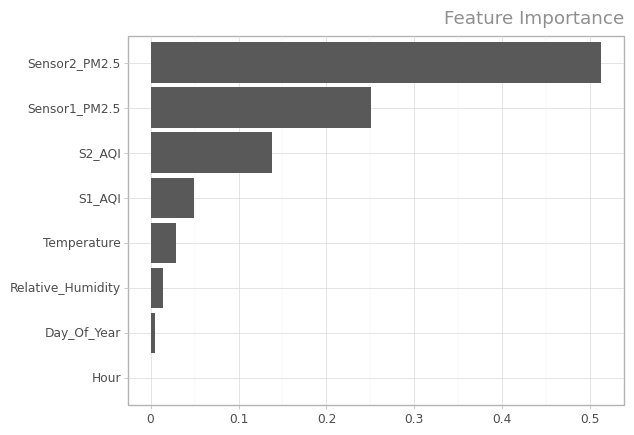

<ggplot: (80879219697)>

In [63]:
(
    ggplot(ft_imp, aes(x="reorder(importance_score, Feature)", y="Feature")) +
    geom_col() +
    coord_flip() +
    labs(x="", y="", title="Feature Importance") +
    theme_light() +
    theme(plot_title= element_text(color="#8F8F8F", ha="right"))
)

### Test Set

All missing values will be imputed with their respective median value and all other feature transformation done on the train set will be used on the test set.

In [37]:
ord_test = test.sort_values(by="Datetime").reset_index(drop=True)

add_df = cfun.add_attributes(ord_test, drop_nan_value=False, fill_nan_value=True)

test_c = add_df.fill_missing_value(fill_fun = "median")
test_c = add_df.add_air_quality_index()
test_c = add_df.add_period_variables(hour=True, dayofyear=True)
test_c = test_c.drop(["ID", "Datetime"], axis = 1)

test_c = full_pipeline.transform(test_c)

In [38]:
final_model = grid_search.best_estimator_

final_prediction = final_model.predict(test_c)

In [22]:
accuracy_score(samplesubmission["Offset_fault"], final_prediction)

0.7908621948634197

In [67]:
confusion_matrix(samplesubmission["Offset_fault"], final_prediction)

array([[100725,  26636],
       [     0,      0]], dtype=int64)

In [68]:
print(classification_report(samplesubmission["Offset_fault"], final_prediction))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88    127361
           1       0.00      0.00      0.00         0

    accuracy                           0.79    127361
   macro avg       0.50      0.40      0.44    127361
weighted avg       1.00      0.79      0.88    127361



The test set seem to have an unusual task of predicting just one class which was the time the PM sensors where considered to have no offset faults. That been said, the model only detect that there were no fault in the sensor signal 79% of the time. Given that there are only 0s i.e non offset sensors we have a percision of 100%.


#### Store Fitted Model

In [25]:
import pickle

# Save Models
with open("final_pm2.5_sensor_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

#### Function to Read And Predict Future Sensor offsets

In [32]:
def make_predictions(model_file_path, new_data=None, data_file_path=None):
    """
    param: model_file_path: The file path to the pickle serialized file.
    param: new_data: The new set of records.
    param: data_file_path : The file path to the new set of records.

    return: pandas serise with predicted values.
    """

    # data transformation
    from function import add_attributes
    from pandas import Series

    if new_data is not None:
        mdl_data = new_data
    
    if data_file_path is not None:
        mdl_data = data_file_path

    ord_rec = mdl_data.sort_values(by="Datetime").reset_index(drop=True)

    add_df = add_attributes(ord_rec, drop_nan_value=False, fill_nan_value=True)

    rec_c = add_df.fill_missing_value(fill_fun = "median")
    rec_c = add_df.add_air_quality_index()
    rec_c = add_df.add_period_variables(hour=True, dayofyear=True)
    rec_c = rec_c.drop(["ID", "Datetime"], axis = 1)

    rec_c = full_pipeline.transform(rec_c)

    # Load model
    with open(model_file_path, "rb") as f:
        model = pickle.load(f)
    
    # Generate predictions
    y_preds = model.predict(rec_c)

    # keep predictions in a pandas series
    y_preds = Series(y_preds, index=ord_rec["ID"], name="pm2.5_sensor_offsets")

    return y_preds